## Examen - Intoducción a la Inteligencia artificial

### 1. Carga y preprocesamiento del dataset

In [1]:
# Importar librerias
import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
# Importar dataset
class Dataset:
    
    instance = None
    data = None
    
    def __new__(cls, fname):
        if Dataset.instance is None:
            print("Creating new dataset instance")
            Dataset.instance = super(Dataset, cls).__new__(cls)
            return Dataset.instance
        else:
            return Dataset.instance
        
    def __init__(self, fname):
        print("Initialising dataset")
        
        try:
            with open(fname + '.pkl','rb') as pkl_file:
                self.data = pickle.load(pkl_file)
        except FileNotFoundError:
            print("CSV file found. Building PKL file...")
            try:
                with open(fname + '.csv') as csv_file:
                    with open(fname + '.pkl','wb') as pkl_file:
                        
                        csv_reader = csv.reader(csv_file, delimiter=',')

                        def generator(csv_reader):
                            for line in csv_reader:
                                yield(line[0],line[1])
                        
                        gen = generator(csv_reader)
                        
                        structure = [('X', np.float32),
                                     ('y', np.float32)]
                        
                        array = np.fromiter(gen, dtype=structure)
                        
                        pickle.dump(array, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)
                        
                    pkl_file.close()
                
                with open(fname + '.pkl','rb') as pkl_file:
                    self.data = pickle.load(pkl_file)
            except FileNotFoundError:
                print("No PKL or CSV named " + fname + " was found.")
            finally:
                csv_file.close()
        finally:
            pkl_file.close()

dataset = Dataset('clase_8_dataset')

Creating new dataset instance
Initialising dataset


(500,)
(500,)


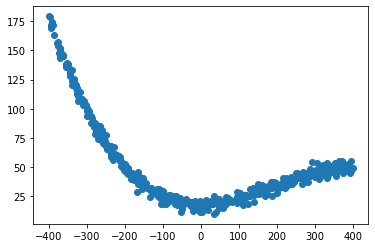

In [3]:
# Graficar dataset
X = dataset.data['X']
y = dataset.data['y']

plt.scatter(X,y);
print(X.shape)
print(y.shape)

In [4]:
# Normalizar el dataset
X = StandardScaler(with_std=True).fit_transform(X.reshape(-1, 1))

In [5]:
# Dividir dataset
def splitDataset(X, y, p):
    
    idx = np.random.permutation(X.shape[0])
    X_sh = X[idx]
    y_sh = y[idx]
    
    lim = int(X.shape[0]*p)

    return X_sh[:lim], X_sh[lim:], y_sh[:lim], y_sh[lim:]

X_train, X_test, y_train, y_test = splitDataset(X, y, 0.8)

### 2. Regresión polinómica (Solución cerrada)

In [6]:
# Regresión Lineal
class LinearRegression():

    def fit(self, x, y):
        if x.ndim == 1:
            w = (x.T @ y) / (x.T @ x)
        else:
            w = np.linalg.inv(x.T @ x) @ x.T @ y
        self.model = w

    def predict(self, x):
        return self.model @ x

In [7]:
# Regresión Polinómica
class PolynomialRegression(LinearRegression):

    def __init__(self, grade):
        self.poly = PolynomialFeatures(grade)

    def fit(self, x, y):
        res = self.poly.fit_transform(x.reshape(-1, 1))
        super().fit(res, y.reshape(-1, 1))

    def predict(self, x):
        return self.poly.fit_transform(x.reshape(-1, 1)) @ self.model

    def fit_transform(self, x, y):
        self.fit(x, y)
        return self.predict(x).reshape(1, -1)

In [8]:
# Métrica de error
class MSE():
    def __call__(self, target, prediction):
        return np.mean((target - prediction) ** 2)

In [14]:
# K-folds
def k_folds(X, y, k, n, X_test, y_test):
    
    p_reg = PolynomialRegression(n)

    mse_eval = MSE()
    mse_list = []
    test_mse_list = []

    chunk_size = int(len(X) / k)

    for i in range(0, len(X), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X) else len(X)

        X_valid = X[i: end]
        y_valid = y[i: end]
        X_train = np.concatenate([X[: i], X[end:]])
        y_train = np.concatenate([y[: i], y[end:]])

        p_reg.fit(X_train, y_train)
        y_pred = p_reg.predict(X_valid)
        y_test_pred = p_reg.predict(X_test)
        
#         plt.figure()
#         plt.scatter(X_valid, y_valid)
#         plt.scatter(X_valid,y_pred)
        
        k_mse = mse_eval(y_valid.reshape(-1, 1), y_pred)
        k_mse_test = mse_eval(y_test.reshape(-1, 1), y_test_pred)
        
        mse_list.append(k_mse)
        test_mse_list.append(k_mse_test)
        
    mean_mse = np.mean(mse_list)
    test_mean_mse = np.mean(test_mse_list)

    return mean_mse, test_mean_mse

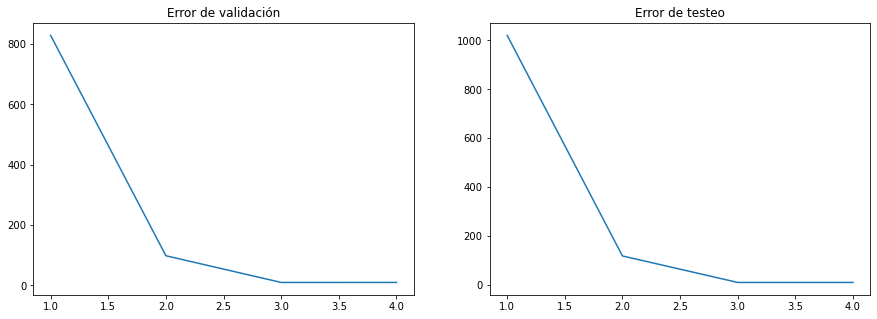

In [21]:
# Usar k-folds por cada grado de regresion polinómica de 1 a 4
grades = [1,2,3,4]
mses = []
test_mses = []

for g in grades:
    mse, test_mse = k_folds(X_train, y_train, 5, g,  X_test, y_test)
    mses.append(mse)
    test_mses.append(test_mse)
    
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(grades, mses);
ax[0].set_title('Error de validación')
ax[1].plot(grades, test_mses);
ax[1].set_title('Error de testeo');

Se selecciona el polinomio de grado 3 como mejor aproximación ya que presenta aproximadamente con el mismo error el modelo pero con una complejidad menor que el polinomio de grado 4

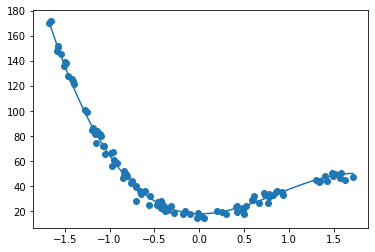

In [35]:
# Gráfica del polinomio y el dataset de test
p_reg = PolynomialRegression(3)
yp_train = p_reg.fit_transform(X_train, y_train)
yp_test = p_reg.predict(X_test)

w_cl = p_reg.model
x = np.linspace(X_test.min(),X_test.max(), 100)
y_cl = w_cl[0] * x**0 + w_cl[1] * x**1 + w_cl[2] * x**2 + w_cl[3] * x**3

plt.plot(x,y_cl)
plt.scatter(X_test, y_test);

mse_eval = MSE()
mse_cl = mse_eval(y_test.reshape(-1, 1), yp_test)

### 3. Regresión polinómica (Solución numérica - Mini-Batch Gradient Descent)

In [40]:
# Mini-Batch Gradient Descent
class MiniBatchGradientDescent:

    def __init__(self, alpha, n_epochs, n_batches, poly=None, lbd=0):
        self.alpha = alpha
        self.n_epochs = n_epochs
        self.model = None
        self.n_batches = n_batches
        self.lbd = lbd

        if poly is not None:
            self.poly = PolynomialFeatures(poly)
        else:
            self.poly = None

    def fit(self, x, y):
        
        if self.poly is not None:
            x = self.poly.fit_transform(x.reshape(-1, 1))

        if x.ndim == 1:
            x = x.reshape(-1, 1)

        n_samples = x.shape[0]
        n_features = x.shape[1]
        
        # Mantener 1/5 del dataset para validacion
        idx = np.random.permutation(n_samples)
        x_sh = x[idx]
        y_sh = y[idx]
        lim = int(n_samples*4/5)
        x = x_sh[:lim]
        y = y_sh[:lim]
        x_val = x_sh[lim:]
        y_val = y_sh[lim:]
        n_samples = x.shape[0]
        
        # Variables para guardar las metricas de errores
        self.train_errors = []
        self.validation_errors = []

        # 1 - Random w initialization
        w = np.random.random(n_features)

        for epoch in range(self.n_epochs):
            # Shuffle samples and create batches
            batch_size = int(n_samples / self.n_batches)
            idx = np.random.permutation(n_samples)
            x_sh = x[idx]
            y_sh = y[idx]

            for i in range(self.n_batches):
                bx = x_sh[i * batch_size:(i + 1) * batch_size]
                by = y_sh[i * batch_size:(i + 1) * batch_size]
                reg_factor = 1 - 2 * self.lbd * self.alpha
                w = reg_factor * w - self.alpha * (-2 / n_samples) * np.sum((by - bx @ w)[:, np.newaxis] * bx, axis=0)
        
            mse_eval = MSE()
            train_error = mse_eval(y_sh, x_sh @ w).round(decimals=1)
            self.train_errors.append(train_error)
            validation_error = mse_eval(y_val, x_val @ w).round(decimals=1)
            self.validation_errors.append(validation_error)
            print("Epoch: " + str(epoch) + " | Training error: " + str(train_error) + " Validation error: " + str(validation_error))
        
        self.model = w

    def predict(self, x):

        if self.poly is not None:
            x = self.poly.fit_transform(x.reshape(-1, 1))

        if x.ndim == 1:
            x = x.reshape(-1, 1)

        return x @ self.model

    def fit_transform(self, x, y):
        self.fit(x, y)
        return self.predict(x).reshape(1, -1)


Epoch: 0 | Training error: 1314.5 Validation error: 1511.3
Epoch: 1 | Training error: 543.7 Validation error: 625.5
Epoch: 2 | Training error: 232.3 Validation error: 266.3
Epoch: 3 | Training error: 104.6 Validation error: 118.0
Epoch: 4 | Training error: 54.8 Validation error: 60.0
Epoch: 5 | Training error: 32.2 Validation error: 33.6
Epoch: 6 | Training error: 22.5 Validation error: 22.4
Epoch: 7 | Training error: 18.3 Validation error: 17.5
Epoch: 8 | Training error: 16.3 Validation error: 15.3
Epoch: 9 | Training error: 15.2 Validation error: 14.2
Epoch: 10 | Training error: 14.6 Validation error: 13.5
Epoch: 11 | Training error: 14.1 Validation error: 13.0
Epoch: 12 | Training error: 13.7 Validation error: 12.7
Epoch: 13 | Training error: 13.3 Validation error: 12.3
Epoch: 14 | Training error: 13.0 Validation error: 12.1
Epoch: 15 | Training error: 12.8 Validation error: 11.9
Epoch: 16 | Training error: 12.5 Validation error: 11.7
Epoch: 17 | Training error: 12.3 Validation erro

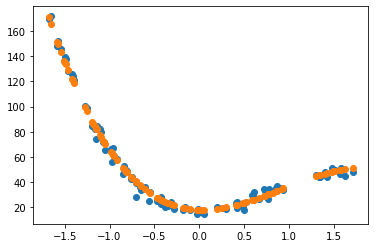

In [48]:
# Entrenar modelo Mini-Batch y reportar error de entrenamiento y validación
bt = MiniBatchGradientDescent(alpha=0.1, n_epochs=50, n_batches=15, poly=3, lbd=0)
bt.fit(X_train, y_train)

y_pred = bt.predict(X_test)
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred);

mse_eval = MSE()
mse_bt = mse_eval(y_test, y_pred)

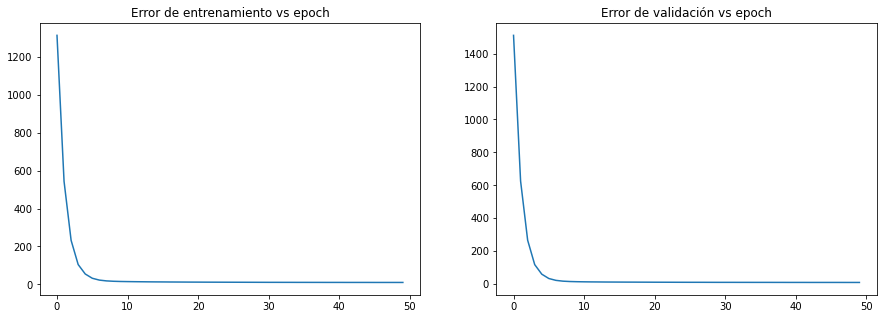

In [49]:
# Graficar errores de entrenamiento y validación
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(bt.train_errors);
ax[0].set_title('Error de entrenamiento vs epoch')
ax[1].plot(bt.validation_errors);
ax[1].set_title('Error de validación vs epoch');

Parámetros de los modelos:
Solución cerrada: [[ 18.094355   -1.0510151  33.002396  -12.504204 ]]
Solución mini-batch: [ 18.14902264  -2.62716901  32.89845168 -11.74932428]


Errores de test (MSE):
Solución cerrada: 9.033233
Solución mini-batch: 9.938350440380988


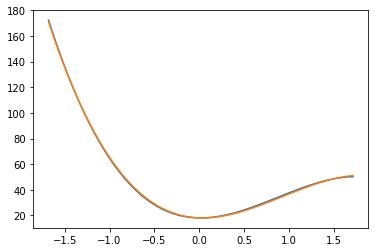

In [50]:
# Comparación de la solución cerrada con Mini-Batch
w_bt = bt.model
x = np.linspace(X_test.min(),X_test.max(), 100)
y_bt = w_bt[0] * x**0 + w_bt[1] * x**1 + w_bt[2] * x**2 + w_bt[3] * x**3

print("Parámetros de los modelos:")
print("Solución cerrada: " + str(w_cl.T))
print("Solución mini-batch: " + str(w_bt))

print("\n")

print("Errores de test (MSE):")
print("Solución cerrada: " + str(mse_cl))
print("Solución mini-batch: " + str(mse_bt))

plt.plot(x,y_cl)
plt.plot(x,y_bt);

### 4. Regresión polinómica (Solución numérica - Mini-Batch Gradient Descent con Regularización Ridge)

Epoch: 0 | Training error: 1392.0 Validation error: 949.4
Epoch: 1 | Training error: 542.9 Validation error: 364.4
Epoch: 2 | Training error: 217.2 Validation error: 141.8
Epoch: 3 | Training error: 95.4 Validation error: 60.5
Epoch: 4 | Training error: 47.2 Validation error: 29.9
Epoch: 5 | Training error: 28.3 Validation error: 18.7
Epoch: 6 | Training error: 20.7 Validation error: 14.6
Epoch: 7 | Training error: 17.3 Validation error: 13.0
Epoch: 8 | Training error: 15.7 Validation error: 12.3
Epoch: 9 | Training error: 14.8 Validation error: 11.9
Epoch: 10 | Training error: 14.3 Validation error: 11.6
Epoch: 11 | Training error: 13.9 Validation error: 11.3
Epoch: 12 | Training error: 13.6 Validation error: 11.1
Epoch: 13 | Training error: 13.3 Validation error: 10.9
Epoch: 14 | Training error: 13.1 Validation error: 10.7
Epoch: 15 | Training error: 12.9 Validation error: 10.5
Epoch: 16 | Training error: 12.7 Validation error: 10.4
Epoch: 17 | Training error: 12.5 Validation error: 

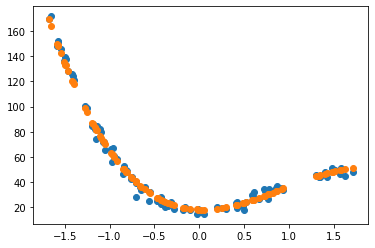

In [69]:
# Entrenar modelo Mini-Batch y reportar error de entrenamiento y validación
btr = MiniBatchGradientDescent(alpha=0.1, n_epochs=50, n_batches=15, poly=3, lbd=0.001)
btr.fit(X_train, y_train)

y_pred = btr.predict(X_test)
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred);

mse_eval = MSE()
mse_btr = mse_eval(y_test, y_pred)

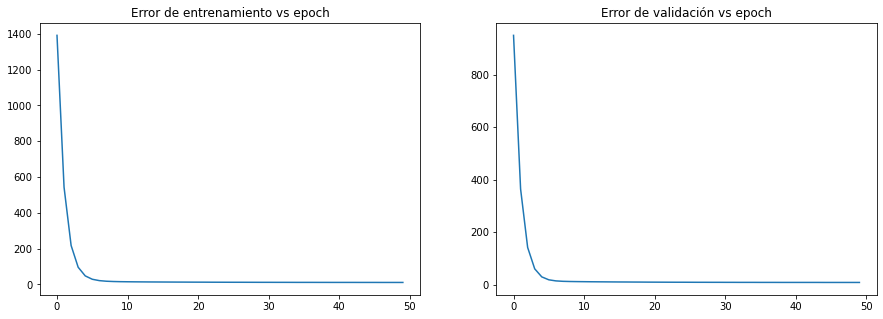

In [70]:
# Graficar errores de entrenamiento y validación
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btr.train_errors);
ax[0].set_title('Error de entrenamiento vs epoch')
ax[1].plot(btr.validation_errors);
ax[1].set_title('Error de validación vs epoch');

Parámetros de los modelos:
Solución mini-batch sin regularización: [ 18.14902264  -2.62716901  32.89845168 -11.74932428]
Solución mini-batch con regularización: [ 18.2518204   -2.53339615  32.56017055 -11.64346074]


Errores de test (MSE):
Solución mini-batch sin regularización: 9.938350440380988
Solución mini-batch con regularización: 10.646899666588716


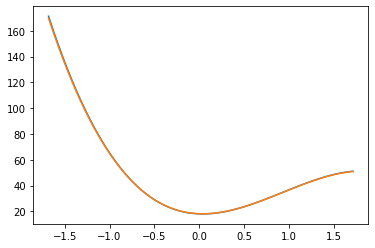

In [71]:
# Comparación de las soluciones numéricas Mini-Batch con y sin regularización
w_bt = bt.model
w_btr = btr.model

x = np.linspace(X_test.min(),X_test.max(), 100)
y_btr = w_btr[0] * x**0 + w_btr[1] * x**1 + w_btr[2] * x**2 + w_btr[3] * x**3

print("Parámetros de los modelos:")
print("Solución mini-batch sin regularización: " + str(w_bt))
print("Solución mini-batch con regularización: " + str(w_btr))

print("\n")

print("Errores de test (MSE):")
print("Solución mini-batch sin regularización: " + str(mse_bt))
print("Solución mini-batch con regularización: " + str(mse_btr))

plt.plot(x,y_bt)
plt.plot(x,y_btr);

Vemos que la solución mini-batch sin regularización ya da resultados muy buenos por sí sola. El agregado de regularización con parámetros grandes empeora el desempeño del modelo. Un valor de 0.001 (muy poca regularización) da resultados similares al modelo sin regularización.